In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Notes

ADDERALL USE:
Legally = 0
Extralegally = 1

RESULTS:
No problems = 0
Tolerance = 1
Minor addiction = 2

USE PATTERN:
Less than once a month = 0
Once a month - once a week = 1
Once a week -  once a day = 2
Daily or even more = 3

ADDERALL DOSE
10 mg or less = 0
11 - 20 mg = 1
21 - 40 mg = 2
41 - 60 mg = 3
61 - 100 mg = 4
More than 100 mg = 5

PHENIBUT DOSE
500 mg or less = 0
501 mg - 1 g = 1
1g - 2g = 2
2g - 5g = 3
5g - 10g = 4
Greater than 10g = 5

NICOTINE USE
I use/d nicotine less than once a week
I use/d nicotine more than three times a day
I use/d nicotine twice or three times a day
I use/d nicotine daily
2 = Between once a week and once a day

MENTAL HEALTH
I have no issues with anxiety = 0
I have not been diagnosed, but I believe I have a problem with anxiety = 1
I have a professionally diagnosed anxiety disorder = 2

TYPE OF NICOTINE
Normal tobacco cigarettes = 0
Gum = 1
Lozenges = 2
E-cigarettes = 3
Snus = 4

The question are here https://docs.google.com/forms/d/e/1FAIpQLSfEek78AYqx5j61EzRX5M6Jy_3fX3xAz4f6gTFtPSEEtkwXug/viewform (the nootropics ratings go from 0 ("worse") to 10 ("better")

Important:

"For each substance, please rate your subjective experience on a scale of 0 to 10. 0 means a substance was totally useless, or had so many side effects you couldn't continue taking it. 1 - 4 means for subtle effects, maybe placebo but still useful. 5 - 9 means strong effects, definitely not placebo. 10 means life-changing. Please as far as possible rate each substance on its own merits - but if a substance only works when stacked with another substance and you're not sure what to do, mention that in the comments."

In [2]:
%config Completer.use_jedi = False #speedup autocomplete

# Cleaning the data

In [3]:
ssc_df = pd.read_csv("fixed.csv")

In [4]:
#select all columns which are not nootropics ratings
person_features_columns = ssc_df.columns[0:6]

side_effects_columns = ["SideEffectsofLSDMicrodosingverysmalldosewithouthallucinogeniceff",
                           "SideEffectsofAdderall",
                           "HowwereyouusingAdderall",
                           "PatternofAdderallUse",
                           "DoseofAdderallhighestdoseyouusedconsistentlyifyoutookmorethanonc",
                           "ResultsofAdderalluse",
                           "SideEffectsofPhenibut",
                           "PatternofPhenibutUse",
                           "Doseofphenibuthighestdoseyouusedconsistentlyifyoutookmorethanonc",
                           "ResultsofPhenibutuse"]

other_features = ssc_df.columns[52:70]

In [5]:
#from IPython.display import display, HTML
#display(HTML(ssc_df.to_html()))

# Using Surprise

### Questions:

- how to take into account external features (sex, age, anxiety) ? (different variance and mean etc)

In [6]:
df_clean = ssc_df.drop(columns = list(person_features_columns) + list(side_effects_columns) + list(other_features))
#transform into a 3 columns (user_id, item_id, rating) matrix for Surprise
df_clean = df_clean.rename_axis('userID').reset_index()
df_clean = df_clean.melt(id_vars = "userID", var_name = "itemID", value_name = "rating")

In [7]:
df_clean = ssc_df.drop(columns = list(person_features_columns) + list(side_effects_columns) + list(other_features))
#transform into a 3 columns (user_id, item_id, rating) matrix for Surprise
df_clean = df_clean.rename_axis('userID').reset_index()
df_clean = df_clean.melt(id_vars = "userID", var_name = "itemID", value_name = "rating")
#remove rows when there is no rating
df_clean = df_clean[df_clean["rating"] != " "]
df_clean = df_clean.reset_index(drop=True)

In [8]:
#from sklearn.preprocessing import LabelEncoder
# change the item names to id for Surprise
#LE = LabelEncoder()
#df_clean['itemID'] = LE.fit_transform(df_clean['itemID'])


In [9]:
#res = cross_validate(SVD(), data, cv=5, measures = ["rmse", "mae", "fcp"], verbose=True)

# Some data exploration

In [10]:
df_clean

,userID,itemID,rating
0,2,Modafinil,5
1,3,Modafinil,9
2,6,Modafinil,4
3,7,Modafinil,5
4,8,Modafinil,3
...,...,...,...
6754,822,Nicotine,9
6755,823,Nicotine,5
6756,824,Nicotine,7
6757,825,Nicotine,10


In [11]:
print("{} users answered, and gave {} ratings".format(len(ssc_df), len(df_clean)))
print("with a mean of {} ratings per user".format(len(df_clean) / len(ssc_df)))

848 users answered, and gave 6759 ratings
with a mean of 7.970518867924528 ratings per user


In [12]:
ratings_per_users = df_clean.groupby("userID").count()["rating"]

In [13]:
ratings_per_users.sum()

6759

<AxesSubplot:>

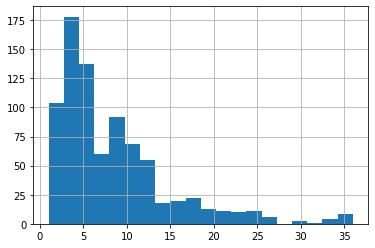

In [14]:
ratings_per_users.hist(bins=20)

In [15]:
print(sum(ratings_per_users == 1))

32


# Model selection

In [16]:
from surprise import NormalPredictor, SVD, NMF, SlopeOne, CoClustering, KNNBasic, KNNWithZScore, KNNWithMeans, KNNBaseline, SVDpp
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, RandomizedSearchCV

## Algorithm selection

In [17]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_clean, reader)


In [18]:

# We can now use this dataset as we please, e.g. calling cross_validate
algorithms = ["SlopeOne", 
              "CoClustering", 
              "SVD", 
              "SVDpp",
              "KNN_means_users", 
              "KNN_zscore_users", 
              "KNN_baselines_users",
              "KNN_means_items", 
              "KNN_zscore_items", 
              "KNN_baselines_items"]
rmse = []
mae = []
fcp = []
print("SlopeOne")
res = cross_validate(SlopeOne(), data, cv=5, measures = ["rmse", "mae", "fcp"], verbose=True)
print(res)
rmse.append(np.mean(res["test_rmse"]))
mae.append(np.mean(res["test_mae"]))
fcp.append(np.mean(res["test_fcp"]))
print("CoClustering")
res = cross_validate(CoClustering(), data, cv=5, measures = ["rmse", "mae", "fcp"], verbose=True)
rmse.append(np.mean(res["test_rmse"]))
mae.append(np.mean(res["test_mae"]))
fcp.append(np.mean(res["test_fcp"]))
print("SVD")
res = cross_validate(SVD(), data, cv=5, measures = ["rmse", "mae", "fcp"], verbose=True)
rmse.append(np.mean(res["test_rmse"]))
mae.append(np.mean(res["test_mae"]))
fcp.append(np.mean(res["test_fcp"]))
print("SVDpp")
res = cross_validate(SVDpp(), data, cv=5, measures = ["rmse", "mae", "fcp"], verbose=True)
rmse.append(np.mean(res["test_rmse"]))
mae.append(np.mean(res["test_mae"]))
fcp.append(np.mean(res["test_fcp"]))
print("KNN... (user based)")
print("with means")
res = cross_validate(KNNWithMeans(), data, cv=5, measures = ["rmse", "mae", "fcp"], verbose=True)
rmse.append(np.mean(res["test_rmse"]))
mae.append(np.mean(res["test_mae"]))
fcp.append(np.mean(res["test_fcp"]))
print("with z-score")
res = cross_validate(KNNWithZScore(), data, cv=5, measures = ["rmse", "mae", "fcp"], verbose=True)
rmse.append(np.mean(res["test_rmse"]))
mae.append(np.mean(res["test_mae"]))
fcp.append(np.mean(res["test_fcp"]))
print("with baselines")
res = cross_validate(KNNBaseline(), data, cv=5, measures = ["rmse", "mae", "fcp"], verbose=True)
rmse.append(np.mean(res["test_rmse"]))
mae.append(np.mean(res["test_mae"]))
fcp.append(np.mean(res["test_fcp"]))
print("KNN... (item based)")
print("with means")
res = cross_validate(KNNWithMeans(sim_options = {'user_based': False}), data, cv=5, measures = ["rmse", "mae", "fcp"], verbose=True)
rmse.append(np.mean(res["test_rmse"]))
mae.append(np.mean(res["test_mae"]))
fcp.append(np.mean(res["test_fcp"]))
print("with z-scores")
res = cross_validate(KNNWithZScore(sim_options = {'user_based': False}), data, cv=5, measures = ["rmse", "mae", "fcp"], verbose=True)
rmse.append(np.mean(res["test_rmse"]))
mae.append(np.mean(res["test_mae"]))
fcp.append(np.mean(res["test_fcp"]))
print("with baselines")
res = cross_validate(KNNBaseline(sim_options = {'user_based': False}), data, cv=5, measures = ["rmse", "mae", "fcp"], verbose=True)
rmse.append(np.mean(res["test_rmse"]))
mae.append(np.mean(res["test_mae"]))
fcp.append(np.mean(res["test_fcp"]))

SlopeOne
Evaluating RMSE, MAE, FCP of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.3862  2.3414  2.4091  2.3931  2.3466  2.3753  0.0267  
MAE (testset)     1.8626  1.8374  1.8707  1.8849  1.8114  1.8534  0.0261  
FCP (testset)     0.5658  0.5810  0.5394  0.5659  0.5885  0.5681  0.0168  
Fit time          0.03    0.03    0.04    0.03    0.06    0.04    0.01    
Test time         0.04    0.05    0.05    0.04    0.05    0.05    0.01    
{'test_rmse': array([2.386214  , 2.34143354, 2.40912565, 2.39314993, 2.34655703]), 'test_mae': array([1.86256892, 1.83744768, 1.87069939, 1.8849496 , 1.81135416]), 'test_fcp': array([0.56579585, 0.58102634, 0.53943333, 0.56594365, 0.58849984]), 'fit_time': (0.02635502815246582, 0.031139135360717773, 0.03924822807312012, 0.031210899353027344, 0.05977511405944824), 'test_time': (0.039418697357177734, 0.0461421012878418, 0.05343198776245117, 0.03727388381958008, 0.05177307128

In [19]:
res_df = pd.DataFrame({"algo":algorithms, "rmse":rmse, "mae":mae, "fcp":fcp})
res_df

,algo,rmse,mae,fcp
0,SlopeOne,2.375296,1.853404,0.568140
1,CoClustering,2.522691,1.974431,0.555576
2,SVD,2.328078,1.853617,0.563088
3,SVDpp,2.396982,1.875759,0.552250
4,KNN_means_users,2.409913,1.904471,0.556563
5,KNN_zscore_users,2.440679,1.913571,0.546748
6,KNN_baselines_users,2.322214,1.842249,0.568748
7,KNN_means_items,2.385486,1.862518,0.569515
8,KNN_zscore_items,2.361710,1.842346,0.570890
9,KNN_baselines_items,2.381464,1.848874,0.576054


The two best ones seem to be SVD and KNN_baselines_users (they seem to be equivalent)

## Hyperparameters tuning

In [20]:
svd_params_dic = {"n_factors":[10, 50, 100, 300], "n_epochs":[20, 40, 100], "lr_all":[0.005, 0.1], "reg_all":[0.02, 0.1, 0.002]}

param_search = RandomizedSearchCV(SVD, svd_params_dic)
param_search.fit(data)

In [21]:
print(param_search.best_params)
print(param_search.best_score)

{'rmse': {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}, 'mae': {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}}
{'rmse': 2.3082569695050035, 'mae': 1.8374777419852948}


In [22]:
knn_params_dic = {"k":[10, 20, 40, 60, 100], 
                  "min_k":[1, 2, 5, 10],
                  "sim_options":{'name': ['pearson_baseline', 'msd', 'cosine'], "user_based":[True]}}

knn_param_search = RandomizedSearchCV(KNNBaseline, knn_params_dic);
knn_param_search.fit(data);

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

/Users/leo/opt/anaconda3/envs/nootropics/lib/python3.8/site-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases 

In [23]:
print(knn_param_search.best_params)
print(knn_param_search.best_score)

{'rmse': {'k': 60, 'min_k': 2, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}, 'mae': {'k': 60, 'min_k': 2, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}}
{'rmse': 2.3081040522732574, 'mae': 1.8321081214813546}


## The best model

In [24]:
final_model = KNNBaseline(k=60, min_k=2, sim_options={'name': 'pearson_baseline', 'user_based':True})
#train on the whole dataset
trainset = data.build_full_trainset()
final_model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### TODO
ensemble the two models ?

# Predictions for new users

## Create a new dataframe

In [25]:
new_user_ratings = {'Modafinil': 6, 
                    'Caffeine': 6,
                    'Coluracetam': None, 
                    'Phenylpiracetam': None,
                    'Theanine': 7,
                    'Noopept': None,
                    'Oxiracetam': None,
                    'Aniracetam': None,
                    'Rhodiola': None,
                    'Creatine': 4,
                    'Piracetam': None,
                    'Ashwagandha': None,
                    'Bacopa': None,
                    'Choline': None,
                    'DMAE': None,
                    'Fasoracetam': None,
                    'SemaxandNASemaxetc': None,
                    'SelankandNASelanketc': None,
                    'Inositol': None,
                    'Seligiline': None,
                    'AlphaBrainproprietaryblend': None,
                    'Cerebrolysin': None,
                    'Melatonin': 8,
                    'Uridine': None,
                    'Tianeptine': None,
                    'MethyleneBlue': None,
                    'Unifiram': None,
                    'PRL853': None,
                    'Emoxypine': None,
                    'Picamilon': None,
                    'Dihexa': None,
                    'Epicorasimmunebooster': None,
                    'LSD': 7,
                    'Adderall': 8,
                    "Phenibut": 6,
                    "Nicotine": 7}

In [26]:
new_user_id = max(df_clean["userID"]) + 1
ratings = np.array(list(new_user_ratings.values()))
rated_mask = ratings != None
ratings = ratings[rated_mask]
items = np.array(list(new_user_ratings.keys()))[rated_mask]
user = np.ones(len(items), dtype="int") * new_user_id
new_user_df = pd.DataFrame({"userID":user, "itemID":items, "rating":ratings})

In [27]:
total_df = df_clean.append(new_user_df)

In [28]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 10))

# The columns must correspond to user id, item id and ratings (in that order).
new_trainset = Dataset.load_from_df(total_df, reader).build_full_trainset()

## Fit the best model

In [29]:
final_model.fit(new_trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [30]:
all_nootropics = new_user_ratings.keys()
predicted_ratings = []
for nootropic in all_nootropics:
    predicted_ratings.append(final_model.predict(new_user_id, nootropic).est)
    
item_baselines = final_model.default_prediction() + final_model.compute_baselines()[1] # mean rating + item baseline ?

result_df = pd.DataFrame({"nootropic":all_nootropics, "predicted_rating":predicted_ratings, "baseline_rating":item_baselines})
    

In [31]:
result_df.sort_values("predicted_rating", ascending=False)

,nootropic,predicted_rating,baseline_rating
33,Adderall,7.997645,7.681135
22,Melatonin,7.916746,5.689561
35,Nicotine,7.158815,5.772261
4,Theanine,7.121568,5.137373
32,LSD,7.107606,6.234681
16,SemaxandNASemaxetc,6.960977,6.167291
24,Tianeptine,6.524165,6.434908
1,Caffeine,6.421540,6.018941
21,Cerebrolysin,6.323260,5.615556
34,Phenibut,6.155112,7.029181


# TODO:
- Use user features (sex, age, self-rated anxiety, depression and ADHD...) (see https://github.com/NicolasHug/Surprise/pull/159 and  https://github.com/martincousi/Surprise/blob/sample_weight/surprise/prediction_algorithms/factorization_machines.py for a discussion on how to use this inside Surprise)
- is Surprise good ? Can I get better results with RandomForest etc ?